# 1. Standard (not graph) AE + GNN for node classification from AE codings

## 

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
from utils import *

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

# Create a KNN graph
def create_knn_graph(data, k):
    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)
    return knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def main():
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)
    
    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:1000]
    y_subset = y_train[:1000]
    
    # Create KNN graph
    k = 30  # Number of neighbors
    knn_graph = create_knn_graph(x_subset, k)
    
    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features
    
    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")
    
    return data



data = main()
generate_train_test(data)

# # Load the Cora dataset
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



# Autoencoder Settings
input_dim = data.num_node_features
hidden_dim = 128
bottleneck_dim = 32
autoencoder = Autoencoder(input_dim, hidden_dim, bottleneck_dim)

# Training the Autoencoder
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
criterion_ae = nn.MSELoss()

for epoch in range(200):
    autoencoder.train()
    optimizer_ae.zero_grad()
    _, reconstructed = autoencoder(data.x)
    loss = criterion_ae(reconstructed, data.x)
    loss.backward()
    optimizer_ae.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Preparing the compressed features for the GNN
autoencoder.eval()
with torch.no_grad():  # Ensure no gradients are computed for the operation within this block
    compressed_features, _ = autoencoder(data.x)
    compressed_features = compressed_features.detach()  # Detach the features from the graph


# Training the GNN
gcn = GCN(bottleneck_dim, hidden_dim, data.num_classes)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion_gcn = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    gcn.train()
    optimizer_gcn.zero_grad()
    out = gcn(compressed_features, data.edge_index)
    loss = criterion_gcn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gcn.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.17191414535045624
Epoch 10, Loss: 0.060203611850738525
Epoch 20, Loss: 0.04484974965453148
Epoch 30, Loss: 0.035658616572618484
Epoch 40, Loss: 0.029977738857269287
Epoch 50, Loss: 0.027112215757369995
Epoch 60, Loss: 0.024609409272670746
Epoch 70, Loss: 0.02408660016953945
Epoch 80, Loss: 0.022634904831647873
Epoch 90, Loss: 0.021732471883296967
Epoch 100, Loss: 0.020886564627289772
Epoch 110, Loss: 0.020244281738996506
Epoch 120, Loss: 0.02023017778992653
Epoch 130, Loss: 0.019089603796601295
Epoch 140, Loss: 0.018619127571582794
Epoch 150, Loss: 0.017822906374931335
Epoch 160, Loss: 0.019492769613862038
Epoch 170, Loss: 0.017420534044504166
Epoch 180, Loss: 0.017160730436444283
Epoch 190, Loss: 0.01652572862803936
Epoch 0, Loss: 4.142853736877441
Epoch 10, Loss: 1.1617416143417358
Epoch 20, Loss: 0.8608624339103699
Epoch 30, Loss: 0.7762224078178406
Epoch 40, Loss: 0.7366983294487
Epoch 50, Loss: 0.711387574672699
Epoch 60, Loss: 0.6663638353347778
Epoch 70, Loss: 0

In [3]:
# Switch model to evaluation mode
gcn.eval()

# No gradient calculation needed for evaluation
with torch.no_grad():
    # Forward pass with the test data
    test_out = gcn(compressed_features, data.edge_index)
    # Use the class with the highest probability as the prediction
    test_pred = test_out.argmax(dim=1)
    # Calculate the number of correct predictions in the test set
    correct = (test_pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    # Calculate the test accuracy
    test_accuracy = correct / data.test_mask.sum().item()




## 

In [4]:
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.72


This obviously does not work. Let's try to fix it.

# 2. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
2-dim output

## 

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 2
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 16

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862969875335693
Epoch: 20, Loss: 1.3863048553466797
Epoch: 30, Loss: 1.3863105773925781
Epoch: 40, Loss: 1.3863130807876587
Epoch: 50, Loss: 1.3863139152526855
Epoch: 60, Loss: 1.3863143920898438
Epoch: 70, Loss: 1.3863143920898438
Epoch: 80, Loss: 1.3863142728805542
Epoch: 90, Loss: 1.3863139152526855
Epoch: 100, Loss: 1.3863134384155273
Epoch 0, Loss: 2.3025596141815186
Epoch 10, Loss: 2.2957961559295654
Epoch 20, Loss: 2.2933406829833984
Epoch 30, Loss: 2.2912118434906006
Epoch 40, Loss: 2.2890994548797607
Epoch 50, Loss: 2.2924962043762207
Epoch 60, Loss: 2.2768568992614746
Epoch 70, Loss: 2.2849979400634766
Epoch 80, Loss: 2.2871642112731934
Epoch 90, Loss: 2.2806379795074463


## 

In [6]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1000


# 3. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
16-dim output

## 

In [7]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 16
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 32

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3856912851333618
Epoch: 20, Loss: 1.3866074085235596
Epoch: 30, Loss: 1.3867714405059814
Epoch: 40, Loss: 1.3868260383605957
Epoch: 50, Loss: 1.386817455291748
Epoch: 60, Loss: 1.3867825269699097
Epoch: 70, Loss: 1.3867390155792236
Epoch: 80, Loss: 1.3866952657699585
Epoch: 90, Loss: 1.3866541385650635
Epoch: 100, Loss: 1.3866171836853027
Epoch 0, Loss: 2.3011960983276367
Epoch 10, Loss: 2.2971198558807373
Epoch 20, Loss: 2.2907934188842773
Epoch 30, Loss: 2.289335250854492
Epoch 40, Loss: 2.2927162647247314
Epoch 50, Loss: 2.2870473861694336
Epoch 60, Loss: 2.283259391784668
Epoch 70, Loss: 2.2929718494415283
Epoch 80, Loss: 2.2832934856414795
Epoch 90, Loss: 2.2839488983154297


## 

In [9]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1100


# 4. Basic Graph AE for DR
super basic 2 GCNConv layers  
2-dim output straight for visualisation

## 

In [10]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862977027893066
Epoch: 20, Loss: 1.3863072395324707
Epoch: 30, Loss: 1.3863134384155273
Epoch: 40, Loss: 1.3863162994384766
Epoch: 50, Loss: 1.386317491531372
Epoch: 60, Loss: 1.3863177299499512
Epoch: 70, Loss: 1.386317491531372
Epoch: 80, Loss: 1.386317491531372
Epoch: 90, Loss: 1.3863170146942139
Epoch: 100, Loss: 1.3863167762756348


## 

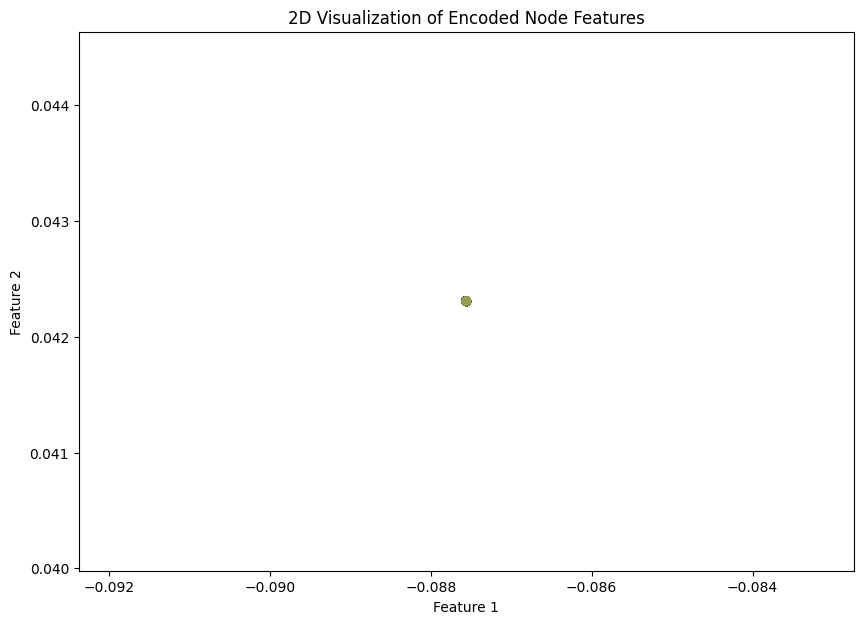

In [12]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 5. Basic Graph AE + tSNE
super basic 2 GCNConv layers  
16-dim output -> tSNE (2dim)

## 

In [13]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_features)



Epoch: 10, Loss: 16.68692970275879
Epoch: 20, Loss: 9.189356803894043
Epoch: 30, Loss: 1.2221870422363281
Epoch: 40, Loss: 1.2287505865097046
Epoch: 50, Loss: 1.1650969982147217
Epoch: 60, Loss: 1.1478140354156494
Epoch: 70, Loss: 1.1351184844970703
Epoch: 80, Loss: 1.1105091571807861
Epoch: 90, Loss: 1.099699854850769
Epoch: 100, Loss: 1.087345838546753
Epoch: 110, Loss: 1.0635576248168945
Epoch: 120, Loss: 1.0495070219039917
Epoch: 130, Loss: 1.0409075021743774
Epoch: 140, Loss: 1.0346180200576782
Epoch: 150, Loss: 1.0314233303070068
Epoch: 160, Loss: 1.0286810398101807
Epoch: 170, Loss: 1.0206893682479858
Epoch: 180, Loss: 1.0115931034088135
Epoch: 190, Loss: 1.0042654275894165
Epoch: 200, Loss: 1.0014631748199463


## 

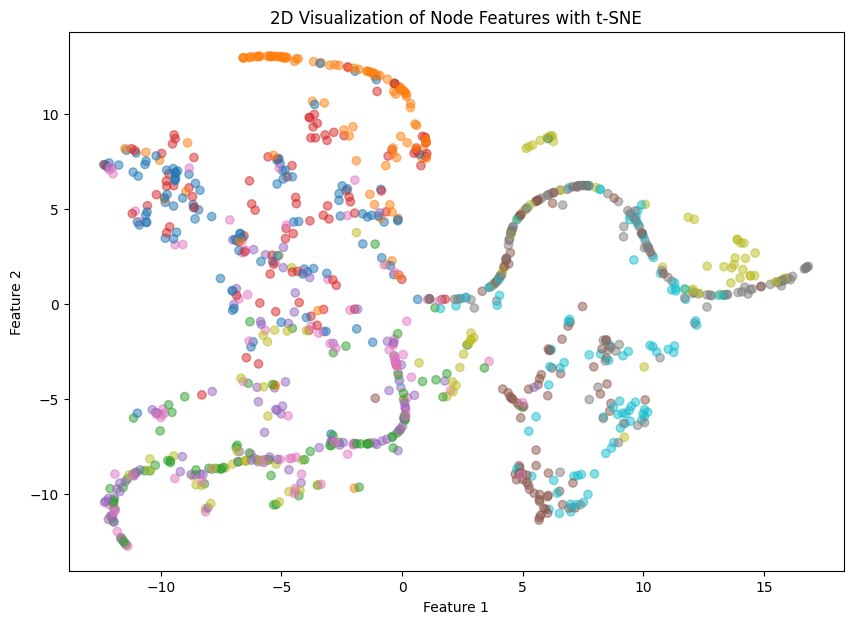

In [15]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 6. Graph AE with skip connections +tSNE
Three GCNConv layers with a skip connection

## 

In [16]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [17]:
class EnhancedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedGCNEncoder, self).__init__()
        self.base_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.base_conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)  # Skip connection
        self.conv3 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.base_conv1(x, edge_index))
        x = F.relu(self.base_conv2(x + skip1, edge_index))  # Combine with skip connection
        return self.conv3(x, edge_index)

# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.919682264328003
Epoch: 20, Loss: 1.3255786895751953
Epoch: 30, Loss: 1.3142913579940796
Epoch: 40, Loss: 1.296247959136963
Epoch: 50, Loss: 1.2726163864135742
Epoch: 60, Loss: 1.2470253705978394
Epoch: 70, Loss: 1.2009809017181396
Epoch: 80, Loss: 1.166285753250122
Epoch: 90, Loss: 1.1535793542861938
Epoch: 100, Loss: 1.1438493728637695
Epoch: 110, Loss: 1.133772611618042
Epoch: 120, Loss: 1.1292144060134888
Epoch: 130, Loss: 1.136924147605896
Epoch: 140, Loss: 1.1311674118041992
Epoch: 150, Loss: 1.1274763345718384
Epoch: 160, Loss: 1.1198630332946777
Epoch: 170, Loss: 1.130386471748352
Epoch: 180, Loss: 1.1221575736999512
Epoch: 190, Loss: 1.1244423389434814
Epoch: 200, Loss: 1.117415189743042


## 

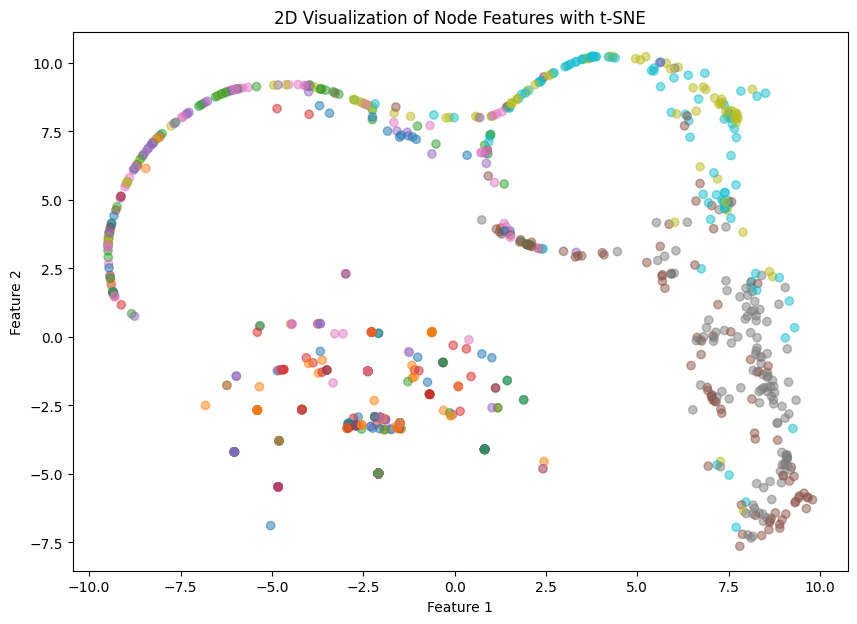

In [18]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 7. Graph AE with skip connections
Three GCNConv layers with a skip connection

## 

In [19]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [20]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862965106964111
Epoch: 20, Loss: 1.3863017559051514
Epoch: 30, Loss: 1.386305332183838
Epoch: 40, Loss: 1.3863067626953125
Epoch: 50, Loss: 1.3863072395324707
Epoch: 60, Loss: 1.3863070011138916
Epoch: 70, Loss: 1.3863071203231812
Epoch: 80, Loss: 1.3863067626953125
Epoch: 90, Loss: 1.3863065242767334
Epoch: 100, Loss: 1.3863060474395752


## 

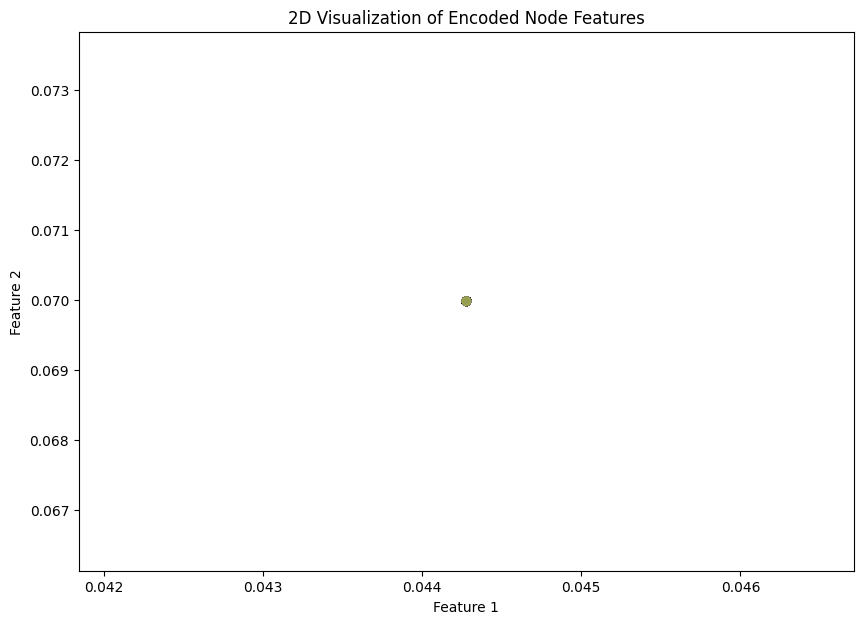

In [21]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')


# 8. Graph AE with attention
Two GATConv layers.

## 

In [22]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [23]:
from torch_geometric.nn import GATConv

class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=8, dropout=0.6)
        # Concatenate multi-head outputs so the final output will be 2*out_channels*8
        self.conv2 = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 8.758416175842285
Epoch: 20, Loss: 8.365209579467773
Epoch: 30, Loss: 7.150402069091797
Epoch: 40, Loss: 7.187531471252441
Epoch: 50, Loss: 7.3134965896606445
Epoch: 60, Loss: 7.710201740264893
Epoch: 70, Loss: 7.333253860473633
Epoch: 80, Loss: 6.672738552093506
Epoch: 90, Loss: 8.010717391967773
Epoch: 100, Loss: 7.319033622741699
Epoch: 110, Loss: 7.932349681854248
Epoch: 120, Loss: 7.431050777435303
Epoch: 130, Loss: 7.707663059234619
Epoch: 140, Loss: 7.371634006500244
Epoch: 150, Loss: 7.720898151397705
Epoch: 160, Loss: 7.450498104095459
Epoch: 170, Loss: 7.591034412384033
Epoch: 180, Loss: 7.705573081970215
Epoch: 190, Loss: 6.674067497253418
Epoch: 200, Loss: 6.491521835327148


## 

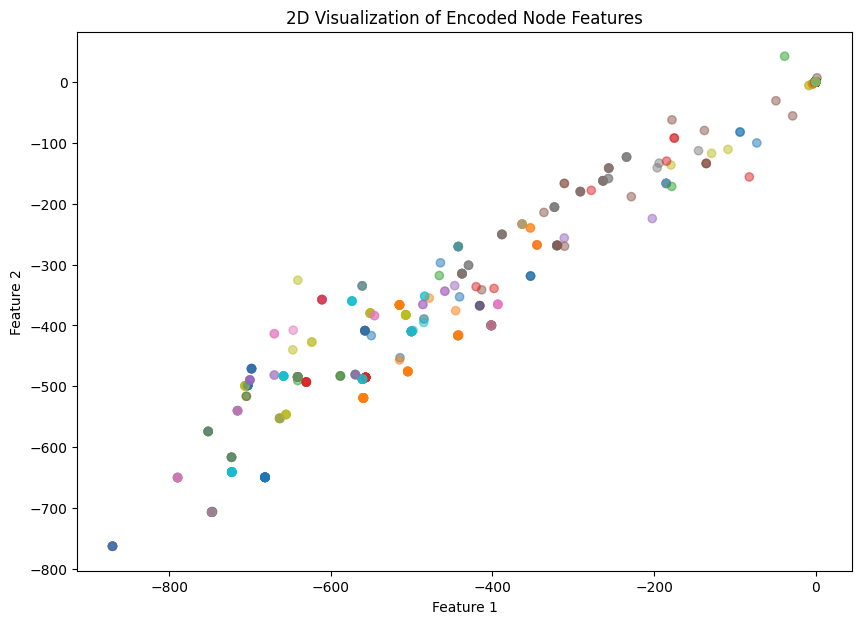

In [24]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 8. Graph AE with attention + tSNE
Two GATConv layers.

## 

In [25]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [26]:
# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()




Epoch: 10, Loss: 9.092657089233398
Epoch: 20, Loss: 8.648473739624023
Epoch: 30, Loss: 8.78738021850586
Epoch: 40, Loss: 6.816779136657715
Epoch: 50, Loss: 6.60338830947876
Epoch: 60, Loss: 6.703708171844482
Epoch: 70, Loss: 6.277688503265381
Epoch: 80, Loss: 6.2995452880859375
Epoch: 90, Loss: 6.2869744300842285
Epoch: 100, Loss: 6.015390396118164
Epoch: 110, Loss: 5.603010177612305
Epoch: 120, Loss: 5.725428581237793
Epoch: 130, Loss: 5.434754848480225
Epoch: 140, Loss: 5.4526519775390625
Epoch: 150, Loss: 6.094032287597656
Epoch: 160, Loss: 5.700604438781738
Epoch: 170, Loss: 6.362695693969727
Epoch: 180, Loss: 5.488611221313477
Epoch: 190, Loss: 6.06950044631958
Epoch: 200, Loss: 6.718721866607666


## 

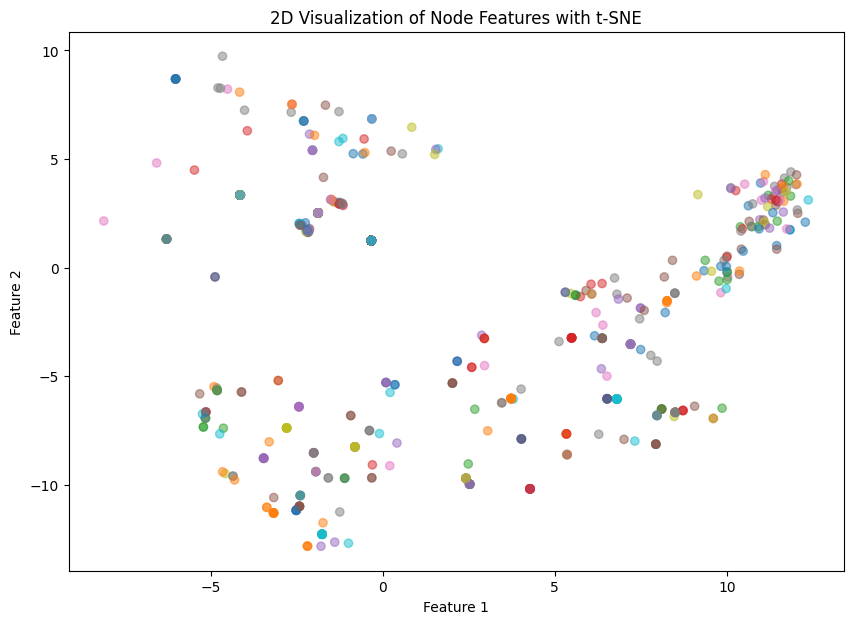

In [27]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 9. Graph AE with skip & residual connections
3 GCNConv layers with skip connections.

## 

In [28]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [29]:
class ComplexGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ComplexGCNEncoder, self).__init__()
        # Encoder with skip connections
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.skip_conv1 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index)) + x  # Residual connection
        x = self.conv3(x, edge_index) + skip1  # Skip connection
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ComplexGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3739300966262817
Epoch: 20, Loss: 1.290147304534912
Epoch: 30, Loss: 1.1939804553985596
Epoch: 40, Loss: 1.1564314365386963
Epoch: 50, Loss: 1.1248064041137695
Epoch: 60, Loss: 1.1262383460998535
Epoch: 70, Loss: 1.123093843460083
Epoch: 80, Loss: 1.1257048845291138
Epoch: 90, Loss: 1.120955467224121
Epoch: 100, Loss: 1.1199421882629395
Epoch: 110, Loss: 1.119260549545288
Epoch: 120, Loss: 1.1195592880249023
Epoch: 130, Loss: 1.111454963684082
Epoch: 140, Loss: 1.1208949089050293
Epoch: 150, Loss: 1.1160775423049927
Epoch: 160, Loss: 1.1107234954833984
Epoch: 170, Loss: 1.1070377826690674
Epoch: 180, Loss: 1.1024068593978882
Epoch: 190, Loss: 1.1028896570205688
Epoch: 200, Loss: 1.0946385860443115


## 

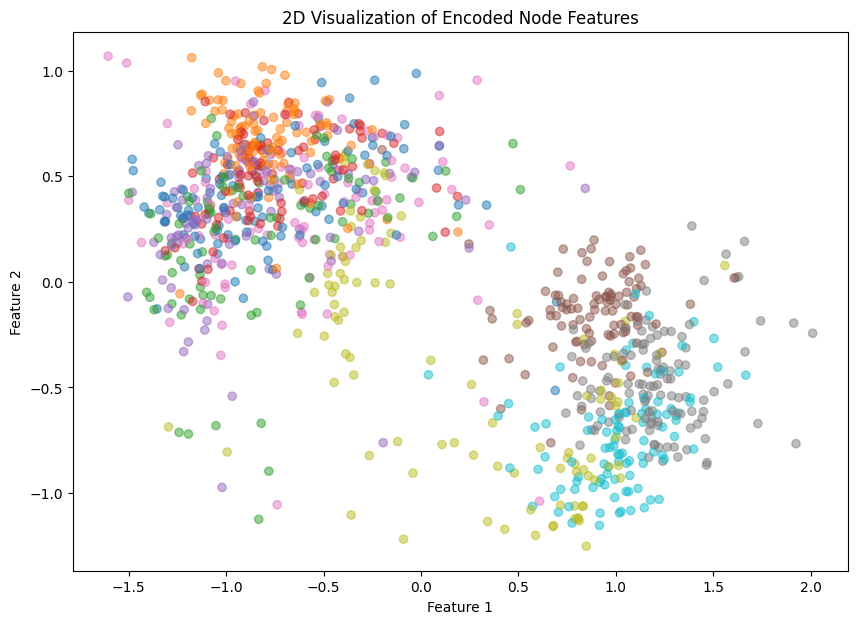

In [30]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 10. Graph AE with residual connection
Three GCNConv layers with a residual connection.

## 

In [31]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [32]:
class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)
        
        x = self.conv3(x, edge_index)
        
        x += identity  # Add the input to the output
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ResidualGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.4018661975860596
Epoch: 20, Loss: 1.2488808631896973
Epoch: 30, Loss: 1.145495057106018
Epoch: 40, Loss: 1.095271110534668
Epoch: 50, Loss: 1.0708314180374146
Epoch: 60, Loss: 1.0595014095306396
Epoch: 70, Loss: 1.0555380582809448
Epoch: 80, Loss: 1.047698974609375
Epoch: 90, Loss: 1.0467145442962646
Epoch: 100, Loss: 1.0320640802383423
Epoch: 110, Loss: 1.0351585149765015
Epoch: 120, Loss: 1.0419739484786987
Epoch: 130, Loss: 1.0286539793014526
Epoch: 140, Loss: 1.032173991203308
Epoch: 150, Loss: 1.0219253301620483
Epoch: 160, Loss: 1.0263254642486572
Epoch: 170, Loss: 1.0200484991073608
Epoch: 180, Loss: 1.029828667640686
Epoch: 190, Loss: 1.024202585220337
Epoch: 200, Loss: 1.0293447971343994


## 

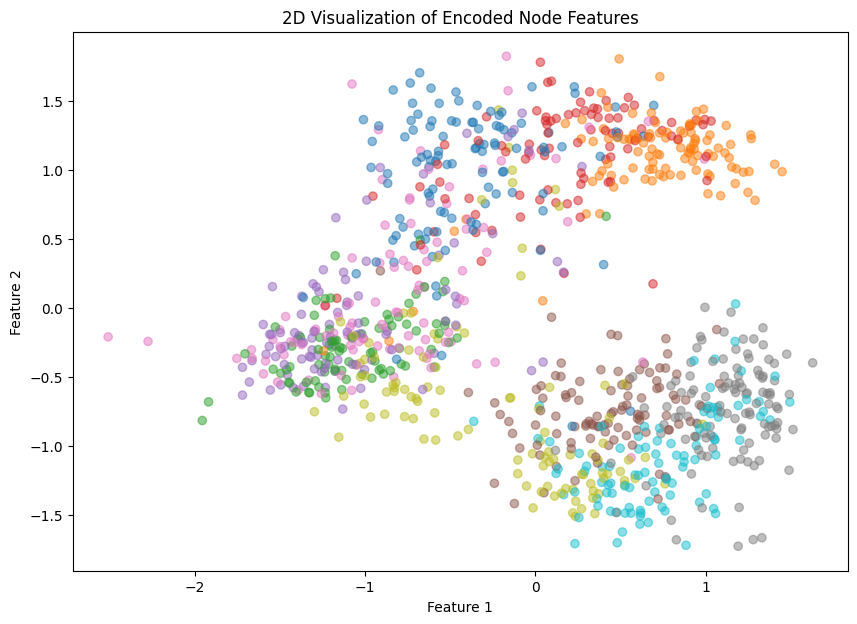

In [33]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 11. Graph AE with attention & normalization
Two GATConv layers with layer normalization.

## 

In [34]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 30000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [35]:
from torch_geometric.nn import GATConv, LayerNorm

class GATWithLayerNormEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3, dropout_rate=0.6):
        super(GATWithLayerNormEncoder, self).__init__()
        # Define the first layer with multiple heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        # For the second layer, we want to reduce the dimension to our desired output dimension
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout_rate)
        # Layer normalization
        self.ln1 = LayerNorm(hidden_channels * heads)
        self.ln2 = LayerNorm(out_channels)

    def forward(self, x, edge_index, dropout_rate=0.6):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.ln1(x)
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(GATWithLayerNormEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

labels = data.y.cpu().numpy()


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3936303853988647
Epoch: 20, Loss: 1.301944613456726
Epoch: 30, Loss: 1.228695034980774
Epoch: 40, Loss: 1.2094342708587646
Epoch: 50, Loss: 1.2110328674316406
Epoch: 60, Loss: 1.1986238956451416
Epoch: 70, Loss: 1.1755692958831787
Epoch: 80, Loss: 1.1535444259643555
Epoch: 90, Loss: 1.1287163496017456
Epoch: 100, Loss: 1.105457067489624
Epoch: 110, Loss: 1.0995410680770874
Epoch: 120, Loss: 1.09208345413208
Epoch: 130, Loss: 1.0988801717758179
Epoch: 140, Loss: 1.0869063138961792
Epoch: 150, Loss: 1.089633822441101
Epoch: 160, Loss: 1.0912752151489258
Epoch: 170, Loss: 1.0876610279083252
Epoch: 180, Loss: 1.0882232189178467
Epoch: 190, Loss: 1.0725972652435303
Epoch: 200, Loss: 1.0826846361160278


## 

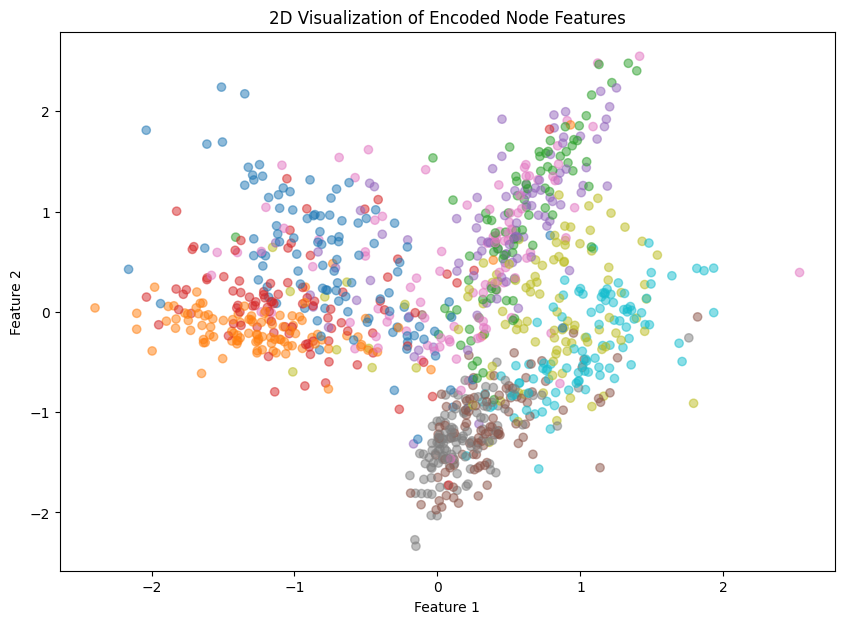

In [36]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')